I57_new_confidence
/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/at_inf_surface/output_960um_method0/output_120um_max_960um_dist_method0/I57_new_confidence/lh/inf_120um_method0_manual_raw_intensity.npz
Loaded ex-vivo subject: I57, hemisphere: lh
/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/at_inf_surface/output_960um_method0/output_120um_max_960um_dist_method0/I57_new_confidence/rh/inf_120um_method0_manual_raw_intensity.npz
I58_new_confidence
/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/at_inf_surface/output_960um_method0/output_120um_max_960um_dist_method0/I58_new_confidence/lh/inf_120um_method0_manual_raw_intensity.npz
Loaded ex-vivo subject: I58, hemisphere: lh
/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/at_inf_surface/output_960um_method0/output_120um_max_960um_dist_method0/I58_new_confidence/rh/inf_120um_method0_manual_raw_intensity.npz
I45_new_confidence
/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/at_inf_surface/output_

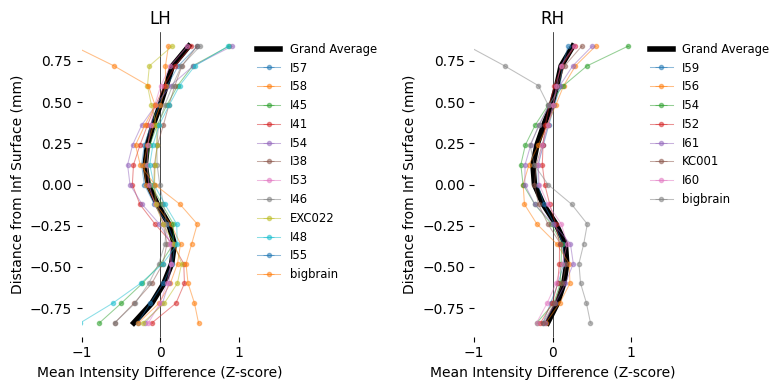

Data shape: (15, 32492)
Distance array: [ 0.84  0.72  0.6   0.48  0.36  0.24  0.12  0.   -0.12 -0.24 -0.36 -0.48
 -0.6  -0.72 -0.84]
Zero index: 7
Depths - Zero: 0.000, Up: -0.240, Down: 0.240


In [7]:
"""
Post-processing analysis script for cortical layer intensity data.
This code processes and visualizes results from quality_control_native_surface_slurm.py

#use conda env: niwrap3912
"""
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore, gaussian_kde
from scipy.stats import linregress
import pickle


# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

# Data parameters
LAYER_TYPE = 'inf' #parameters can be 'inf', 'pial', 'white'
RESOLUTION = '120um'  # 120um or 240um
DEPTH = '960um' #960 or 2000um
STEPS = 2
# Analysis parameters
data_type = "diff"
do_zscore = True
do_zscore_before_diff = False
add_bigbrain = True

# File paths
base_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo"

#data_base_path = f"/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/at_inf_surface/output_{DEPTH}_method0/output_{RESOLUTION}_max_{DEPTH}_dist_method0"
data_base_path = f"/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/at_{LAYER_TYPE}_surface/output_{DEPTH}_method0/output_{RESOLUTION}_max_{DEPTH}_dist_method0"
bigbrain_base_path = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii'




# Visualization parameters
xlim_max = 1
figure_size_depth_profiles = (8, 4)
figure_size_kde = (14, 4)
figure_size_scatter = (4, 3)

# Analysis depth positions (relative to zero index)
if RESOLUTION == '120um':
    voxel_offset_up = STEPS
    voxel_offset_down = -STEPS
else:
    voxel_offset_up = 2
    voxel_offset_down = -2

# KDE parameters
kde_x_range = (-10, 10)
kde_n_points = 500

# ============================================================================
# DATA PROCESSING FUNCTIONS
# ============================================================================

# Initialize data containers
all_data = {
    'lh': {'intensity_data': [], 'subject_names': []},
    'rh': {'intensity_data': [], 'subject_names': []}
}

def process_intensity_data(data_array, data_type, do_zscore):
    """Process intensity data with optional differencing and z-scoring."""
    
    if data_type == 'diff':
        # Apply z-scoring before differencing if requested
        if do_zscore_before_diff:
            data_array = zscore(data_array, axis=0)
        
        # Calculate differences between adjacent elements
        data_array = np.diff(data_array, axis=0)
        
        # Apply z-scoring after differencing if requested and not done before
        if do_zscore and not do_zscore_before_diff:
            data_array = zscore(data_array, axis=0)
            
    elif data_type == 'raw':
        # Apply z-scoring for raw data if requested
        if do_zscore:
            data_array = zscore(data_array, axis=0)
            
    else:
        raise ValueError(f"Invalid data_type: {data_type}. Must be 'diff' or 'raw'")

    return data_array


# Process ex-vivo subjects
for subjects in os.listdir(base_path):
    if subjects:
        print(subjects)
        for hemispheres in ['lh', 'rh']:
            intensity_file_path = os.path.join(
                data_base_path, subjects, 
                f"{hemispheres}/{LAYER_TYPE}_{RESOLUTION}_method0_manual_raw_intensity.npz"
            )

            print(intensity_file_path)
            if os.path.exists(intensity_file_path):
                data = np.load(intensity_file_path, allow_pickle=True)
                dist_array = data['dist_array']
                
                # Process data
                tmp_dat = process_intensity_data(data['all_values'], data_type, do_zscore)
                
                # Store data by hemisphere
                clean_subject_name = subjects.replace('_new_confidence', '')
                print(f"Loaded ex-vivo subject: {clean_subject_name}, hemisphere: {hemispheres}")
                
                all_data[hemispheres]['intensity_data'].append(tmp_dat)
                all_data[hemispheres]['subject_names'].append(clean_subject_name)


if add_bigbrain:
    # Load BigBrain data
    for hemi in ['lh', 'rh']:
        #specify the layer surface for the BigBrain data to match the ex vivo data
        if LAYER_TYPE == 'inf':
            LAYER_SURFACE = 'layer3'
            SUBPATH = 'at_inf_surface'
        elif LAYER_TYPE == 'pial':
            LAYER_SURFACE = 'layer0'
            SUBPATH = 'at_pial_surface'
        elif LAYER_TYPE == 'white':
            LAYER_SURFACE = 'layer6'
            SUBPATH = 'at_white_surface'
        else:
            raise ValueError(f"Invalid LAYER_TYPE: {LAYER_TYPE}")

        bb_file_path = os.path.join(bigbrain_base_path, SUBPATH, f'bigbrain_{hemi}_{LAYER_SURFACE}_{RESOLUTION}_max_{DEPTH}_method0_manual_raw_intensity.npz')
        
        if os.path.exists(bb_file_path):
            bb_data = np.load(bb_file_path)['all_values']
            bb_data = process_intensity_data(bb_data, data_type, do_zscore)
            
            all_data[hemi]['intensity_data'].append(bb_data)
            all_data[hemi]['subject_names'].append('bigbrain')
            print(f"Loaded BigBrain data for hemisphere: {hemi}")


dist_array = np.load(bb_file_path)['dist_array']
# Find zero index for distance array
zero_indices = np.where(dist_array == 0)[0]
if len(zero_indices) > 0:
    zero_index = zero_indices[0]
else:
    zero_index = np.argmin(np.abs(dist_array))
    print(f"No exact zero found, using closest value at index {zero_index} with value {dist_array[zero_index]}")

# Create convenient access variables
lh_intensity_data_uncut = all_data['lh']['intensity_data']
rh_intensity_data_uncut = all_data['rh']['intensity_data']
lh_subject_names = all_data['lh']['subject_names']
rh_subject_names = all_data['rh']['subject_names']

# Print summary
print(f"\nData loading summary:")
print(f"Left hemisphere: {len(lh_subject_names)} subjects - {lh_subject_names}")
print(f"Right hemisphere: {len(rh_subject_names)} subjects - {rh_subject_names}")

# Calculate rolling average of consecutive pairs for distance array
dist_array_avg = np.array([(dist_array[i] + dist_array[i + 1]) / 2 for i in range(len(dist_array) - 1)])
print(f"Distance array average: {dist_array_avg}")

# Plot depth profiles for both hemispheres
plt.figure(figsize=figure_size_depth_profiles)

for subplot_idx, (hemi, subject_names, subject_data) in enumerate([
    ('lh', lh_subject_names, lh_intensity_data_uncut),
    ('rh', rh_subject_names, rh_intensity_data_uncut)
], 1):
    
    plt.subplot(1, 2, subplot_idx)

    # Plot each subject
    grand_average_intensity = []
    for i, tmp in enumerate(subject_data):
        mean_intensity = np.mean(tmp, axis=1)
        sem_intensity = np.std(tmp, axis=1) / np.sqrt(tmp.shape[1] - 1)
        
        yvals = []
        if data_type == 'raw':
            yvals = dist_array
        elif data_type == 'diff':
            yvals = dist_array_avg

        plt.errorbar(mean_intensity, yvals, xerr=sem_intensity, 
                    fmt='-o', linewidth=0.75, markersize=3, alpha=0.5, 
                    label=subject_names[i])
        grand_average_intensity.append(mean_intensity)

    # Plot grand average
    grand_average_intensity = np.nanmean(grand_average_intensity, axis=0)
    plt.plot(grand_average_intensity, yvals, 'k-', linewidth=4, 
             alpha=1, label='Grand Average', zorder=0)
    
    # Formatting
    if do_zscore:
        plt.xlim(-xlim_max, xlim_max)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.xlabel('Mean Intensity Difference (Z-score)')
    plt.ylabel('Distance from Inf Surface (mm)')
    plt.title(f'{hemi.upper()}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
    
    # Remove spines
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()

# Analyze intensity data at specific depth positions
print(f"Data shape: {subject_data[0].shape}")
print(f"Distance array: {dist_array_avg}")

# Find key depth positions using configured offsets
zero_index = np.where(dist_array_avg == 0)[0][0]
x_voxel_up = zero_index + voxel_offset_up
x_voxel_down = zero_index + voxel_offset_down

print(f"Zero index: {zero_index}")
print(f"Depths - Zero: {dist_array_avg[zero_index]:.3f}, Up: {dist_array_avg[x_voxel_up]:.3f}, Down: {dist_array_avg[x_voxel_down]:.3f}")


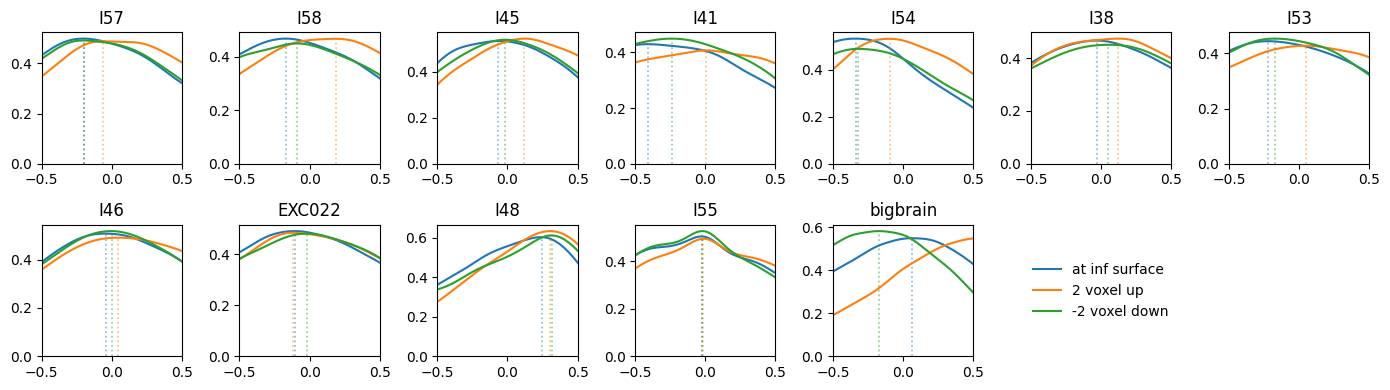

In [24]:
# Plot KDE distributions for each subject
hemi = 'lh'
subject_data = lh_intensity_data_uncut if hemi == 'lh' else rh_intensity_data_uncut
subject_names = lh_subject_names if hemi == 'lh' else rh_subject_names
n_subjects = len(subject_data)

fig, axes = plt.subplots(2, 7, figsize=figure_size_kde)
axes = axes.flatten()


# Storage for peak distances
peak_distances_all_subjects = {
    'at_surface': [],
    'x_voxel_up': [],
    'x_voxel_down': []
}

# Define positions for analysis
positions = [
    (zero_index, f'at {LAYER_TYPE} surface', 'at_surface'),
    (x_voxel_up, f'{voxel_offset_up} voxel up', 'x_voxel_up'),
    (x_voxel_down, f'{voxel_offset_down} voxel down', 'x_voxel_down')
]

for i, tmp in enumerate(subject_data):
    ax = axes[i]
    tmp = np.where(~np.isnan(tmp), tmp, 0)  # Remove NaN values
    
    for pos_idx, label, key in positions:
        tmp_kde = tmp[pos_idx, :]
        #check if there is any Nan values
        #x_range = np.linspace(kde_x_range[0], kde_x_range[1], kde_n_points)
        x_range = np.linspace(np.nanmin(tmp_kde), np.nanmax(tmp_kde), kde_n_points)
        kde = gaussian_kde(tmp_kde)
        kde_vals = kde(x_range)
        line = ax.plot(x_range, kde_vals, alpha=1, linewidth=1.5, label=label)
        
        # Add peak indicator and store peak distance
        peak_idx = np.argmax(kde_vals)
        peak_x, peak_y = x_range[peak_idx], kde_vals[peak_idx]
        ax.plot([peak_x, peak_x], [0, peak_y], ':', alpha=0.5, 
                linewidth=1.25, color=line[0].get_color())
        
        peak_distances_all_subjects[key].append(peak_x)
    
    if do_zscore:
        ax.set_xlim(-0.5, 0.5)
    else:
        #ax.set_xlim(np.nanpercentile(tmp[pos_idx, :], 20), np.nanpercentile(tmp[pos_idx, :],90)) #for inf
        ax.set_xlim(np.nanpercentile(tmp[pos_idx, :], 1), np.nanpercentile(tmp[pos_idx, :],99)) #for white

    ax.set_ylim(bottom=0)
    ax.set_title(f'{subject_names[i]}')

# Add legend
if n_subjects < len(axes):
    legend_ax = axes[n_subjects]
    legend_ax.axis('off')
    for pos_idx, label, key in positions:
        legend_ax.plot([], [], alpha=1, linewidth=1.5, label=label)
    legend_ax.legend(loc='center', frameon=False)

# Hide remaining empty subplots
for j in range(n_subjects + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()



Peak distances for all subjects:
at_surface: [np.float64(-0.19838382394450527), np.float64(-0.1709395399172755), np.float64(-0.06426872034368891), np.float64(-0.40658254621519374), np.float64(-0.338837121114695), np.float64(-0.03246431294106378), np.float64(-0.2217744973280502), np.float64(-0.042225842590084106), np.float64(-0.10312013757962424), np.float64(0.24307283192786455), np.float64(-0.024555729385340008), np.float64(0.0647067548104725)]
  Mean: -0.108, Std: 0.168
x_voxel_up: [np.float64(-0.0654781673704532), np.float64(0.18778182206267058), np.float64(0.11725690744112338), np.float64(0.001683928964430148), np.float64(-0.09555258101076358), np.float64(0.1180535260923481), np.float64(0.047385177010284885), np.float64(0.04205340572714178), np.float64(-0.11670454674465214), np.float64(0.3037395013151265), np.float64(-0.017812697905100094), np.float64(0.5402866085463436)]
  Mean: 0.089, Std: 0.179
x_voxel_down: [np.float64(-0.19900185174135254), np.float64(-0.09304795510598796), np

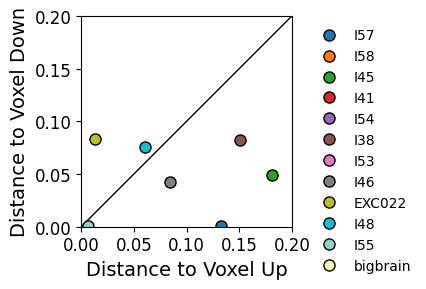

In [25]:

# Print peak distances summary
print("\nPeak distances for all subjects:")
for key, values in peak_distances_all_subjects.items():
    print(f"{key}: {values}")
    print(f"  Mean: {np.mean(values):.3f}, Std: {np.std(values):.3f}")

# Convert to numpy arrays for analysis
at_inf_surface = np.array(peak_distances_all_subjects['at_surface'])
voxel_up = np.array(peak_distances_all_subjects['x_voxel_up'])
voxel_down = np.array(peak_distances_all_subjects['x_voxel_down'])

# Create scatter plot with distinguished colors
n_subjects = len(subject_names)
colors = plt.cm.tab10(np.arange(n_subjects)) if n_subjects <= 10 else \
         np.vstack([plt.cm.tab10(np.arange(10)), plt.cm.Set3(np.arange(n_subjects - 10))])

plt.figure(figsize=figure_size_scatter)
for i, subject_name in enumerate(subject_names):
    plt.plot(abs(voxel_up[i] - at_inf_surface[i]), 
             abs(voxel_down[i] - at_inf_surface[i]), 'o', 
             color=colors[i], label=subject_name, markersize=8, 
             markeredgecolor='black')

plt.legend(subject_names, bbox_to_anchor=(1.05, 1), loc='upper left', 
           frameon=False, fontsize=10)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Distance to Voxel Up', fontsize=14)
plt.ylabel('Distance to Voxel Down', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.plot([0, 1.5], [0, 1.5], 'k-', linewidth=1, zorder=0)  # x=y line
if do_zscore:
    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
plt.tight_layout()
plt.show()

#voxels_up = np.abs(voxel_up - at_inf_surface)
#voxels_down = np.abs(voxel_down - at_inf_surface)


new 12 ['I54', 'I57', 'I58', 'I45', 'I41', 'I38', 'I53', 'I46', 'EXC022', 'I48', 'I55', 'bigbrain']


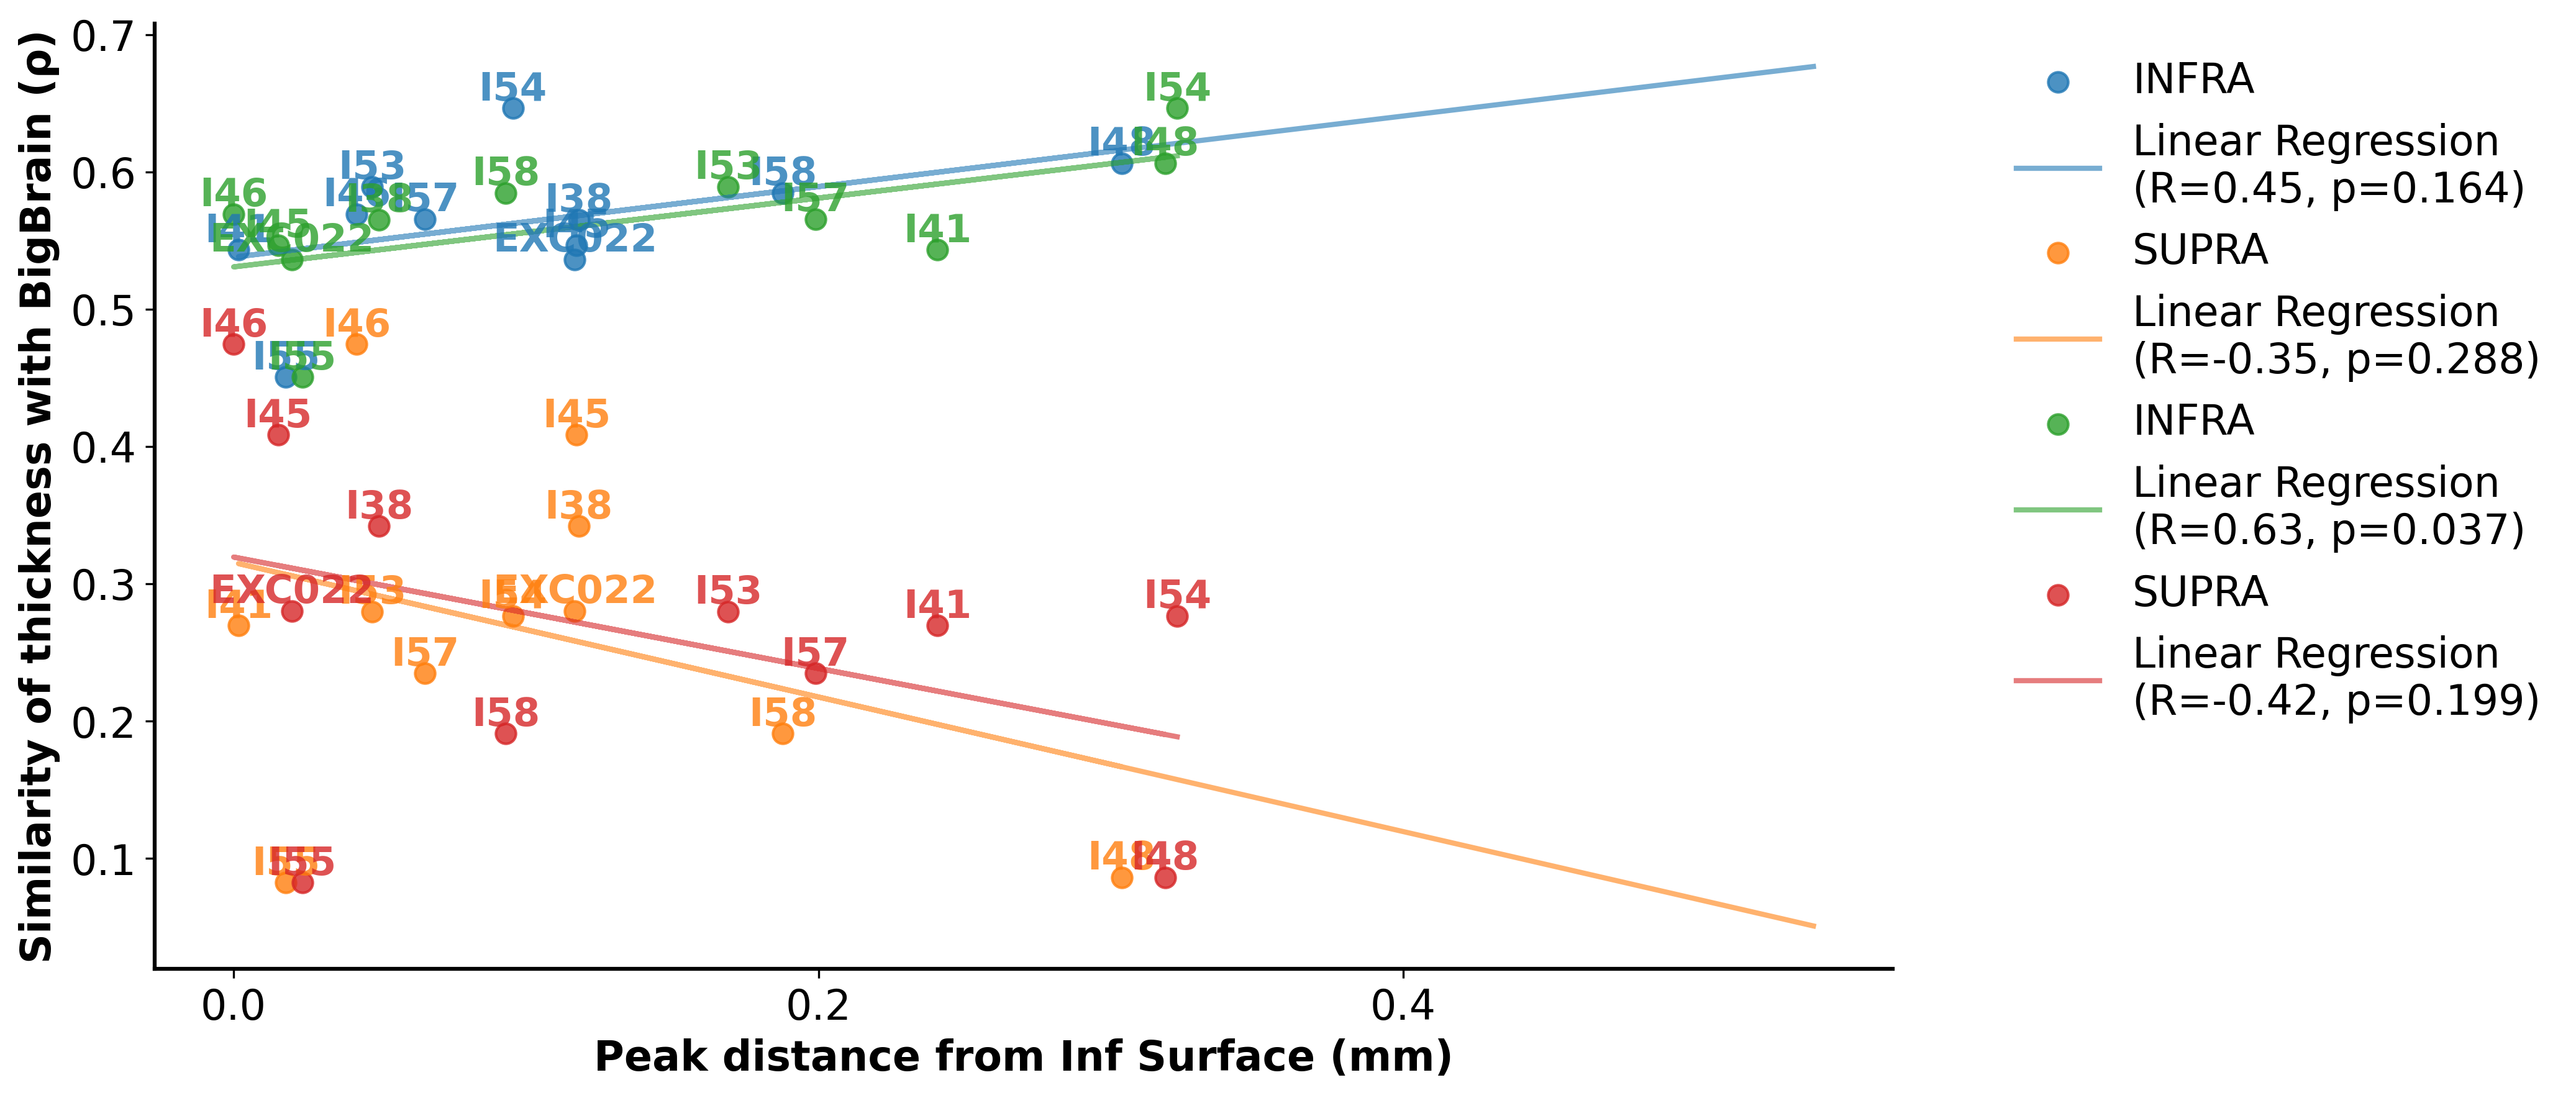

In [26]:

#load the correlation data (from visualize_brain.ipynb)
#/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/layer_project/cortical_layer/jupyter-notebook/visualization
'''
with open('/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/layer_project/cortical_layer/jupyter-notebook/visualization/thickness_corr_wrt_bigbrain_32k.pkl', 'rb') as f:
    data = pickle.load(f)
    subject_names_corr = data['subject_names']
    thickness_corr_wrt_bigbrain = data['thickness_corr_wrt_bigbrain']

'''
with open('/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/layer_project/cortical_layer/jupyter-notebook/visualization/thickness_corr_wrt_bigbrain.pkl', 'rb') as f:
    data = pickle.load(f)
    subject_names_corr = data['subject_names']
    thickness_corr_wrt_bigbrain = data['thickness_corr_wrt_bigbrain']

#get the reorder index of the subject names_corr[hemi] in subject_names
reorder_index = [subject_names.index(subject) for subject in subject_names_corr[hemi]]
#reorder subject_names with the reorder_index
subject_names_reordered = [subject_names[i] for i in reorder_index]
print('new',len(subject_names_reordered),subject_names_reordered)


fontsize = 16
voxel_ave = (voxel_up + voxel_down) / 2
YVAR = 'ave1'
if YVAR == 'ave':
    voxels_all = [voxel_ave]
else:
    voxels_all = [np.abs(voxel_up), np.abs(voxel_down)]


'''
YVAR = 'up'#(1) 'ave' (2) 'down' (3) 'up'
if YVAR == 'ave':
    independent_variable = (voxels_up + voxels_down) / 2
else:
    independent_variable = [voxels_up, voxels_down]
elif YVAR == 'down':
    independent_variable = voxels_down
elif YVAR == 'up':
    independent_variable = voxels_up
'''

plt.figure(figsize=(14,6), dpi=300)
for i, independent_variable in enumerate(voxels_all):
    var_= independent_variable[reorder_index]#this should be reordered so that it matches with the thickness_corr_wrt_bigbrain
    # Set high DPI for better quality

    for j, layer_type in enumerate(['infra','supra']):

        plt.scatter(var_[:-1], thickness_corr_wrt_bigbrain[hemi][layer_type][:-1], 
                    label=layer_type.upper(), s=60, alpha=0.8)
        #calculate linear regression
        slope, intercept, r_value, p_value, std_err = linregress(var_[:-1], thickness_corr_wrt_bigbrain[hemi][layer_type][:-1])
        
        #plot the linear regression
        plt.plot(var_, slope*var_ + intercept, 
                label=f'Linear Regression\n(R={r_value:.2f}, p={p_value:.3f})', linewidth=2, alpha=0.6)
        for i, subject in enumerate(subject_names_reordered):
            plt.annotate(subject, (var_[i], thickness_corr_wrt_bigbrain[hemi][layer_type][i]), 
                        fontsize=fontsize-1, ha='center', va='bottom', alpha=0.8, fontweight='bold',
                        color=plt.gca().collections[-1].get_facecolors()[0])


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=fontsize)  

plt.xlabel(f'Peak distance from {LAYER_TYPE.capitalize()} Surface (mm)', fontsize=fontsize, fontweight='bold')
plt.ylabel('Similarity of thickness with BigBrain (ρ)', fontsize=fontsize, fontweight='bold')
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
#only set the minimum of x-axis

# Set fewer ticks on x-axis
plt.locator_params(axis='x', nbins=4)

#remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.tight_layout()
#save the figure
SUBPATH = 'corr_wrt_bigbrain_figure'
#create subfolder if it doesn't exist
#os.makedirs(SUBPATH, exist_ok=True)
#plt.savefig(f'{SUBPATH}/{hemi}_thickness_corr_wrt_bigbrain_{layer_type}_{RESOLUTION}.png', dpi=300)
#
#plt.close()


new 12 ['I54', 'I57', 'I58', 'I45', 'I41', 'I38', 'I53', 'I46', 'EXC022', 'I48', 'I55', 'bigbrain']


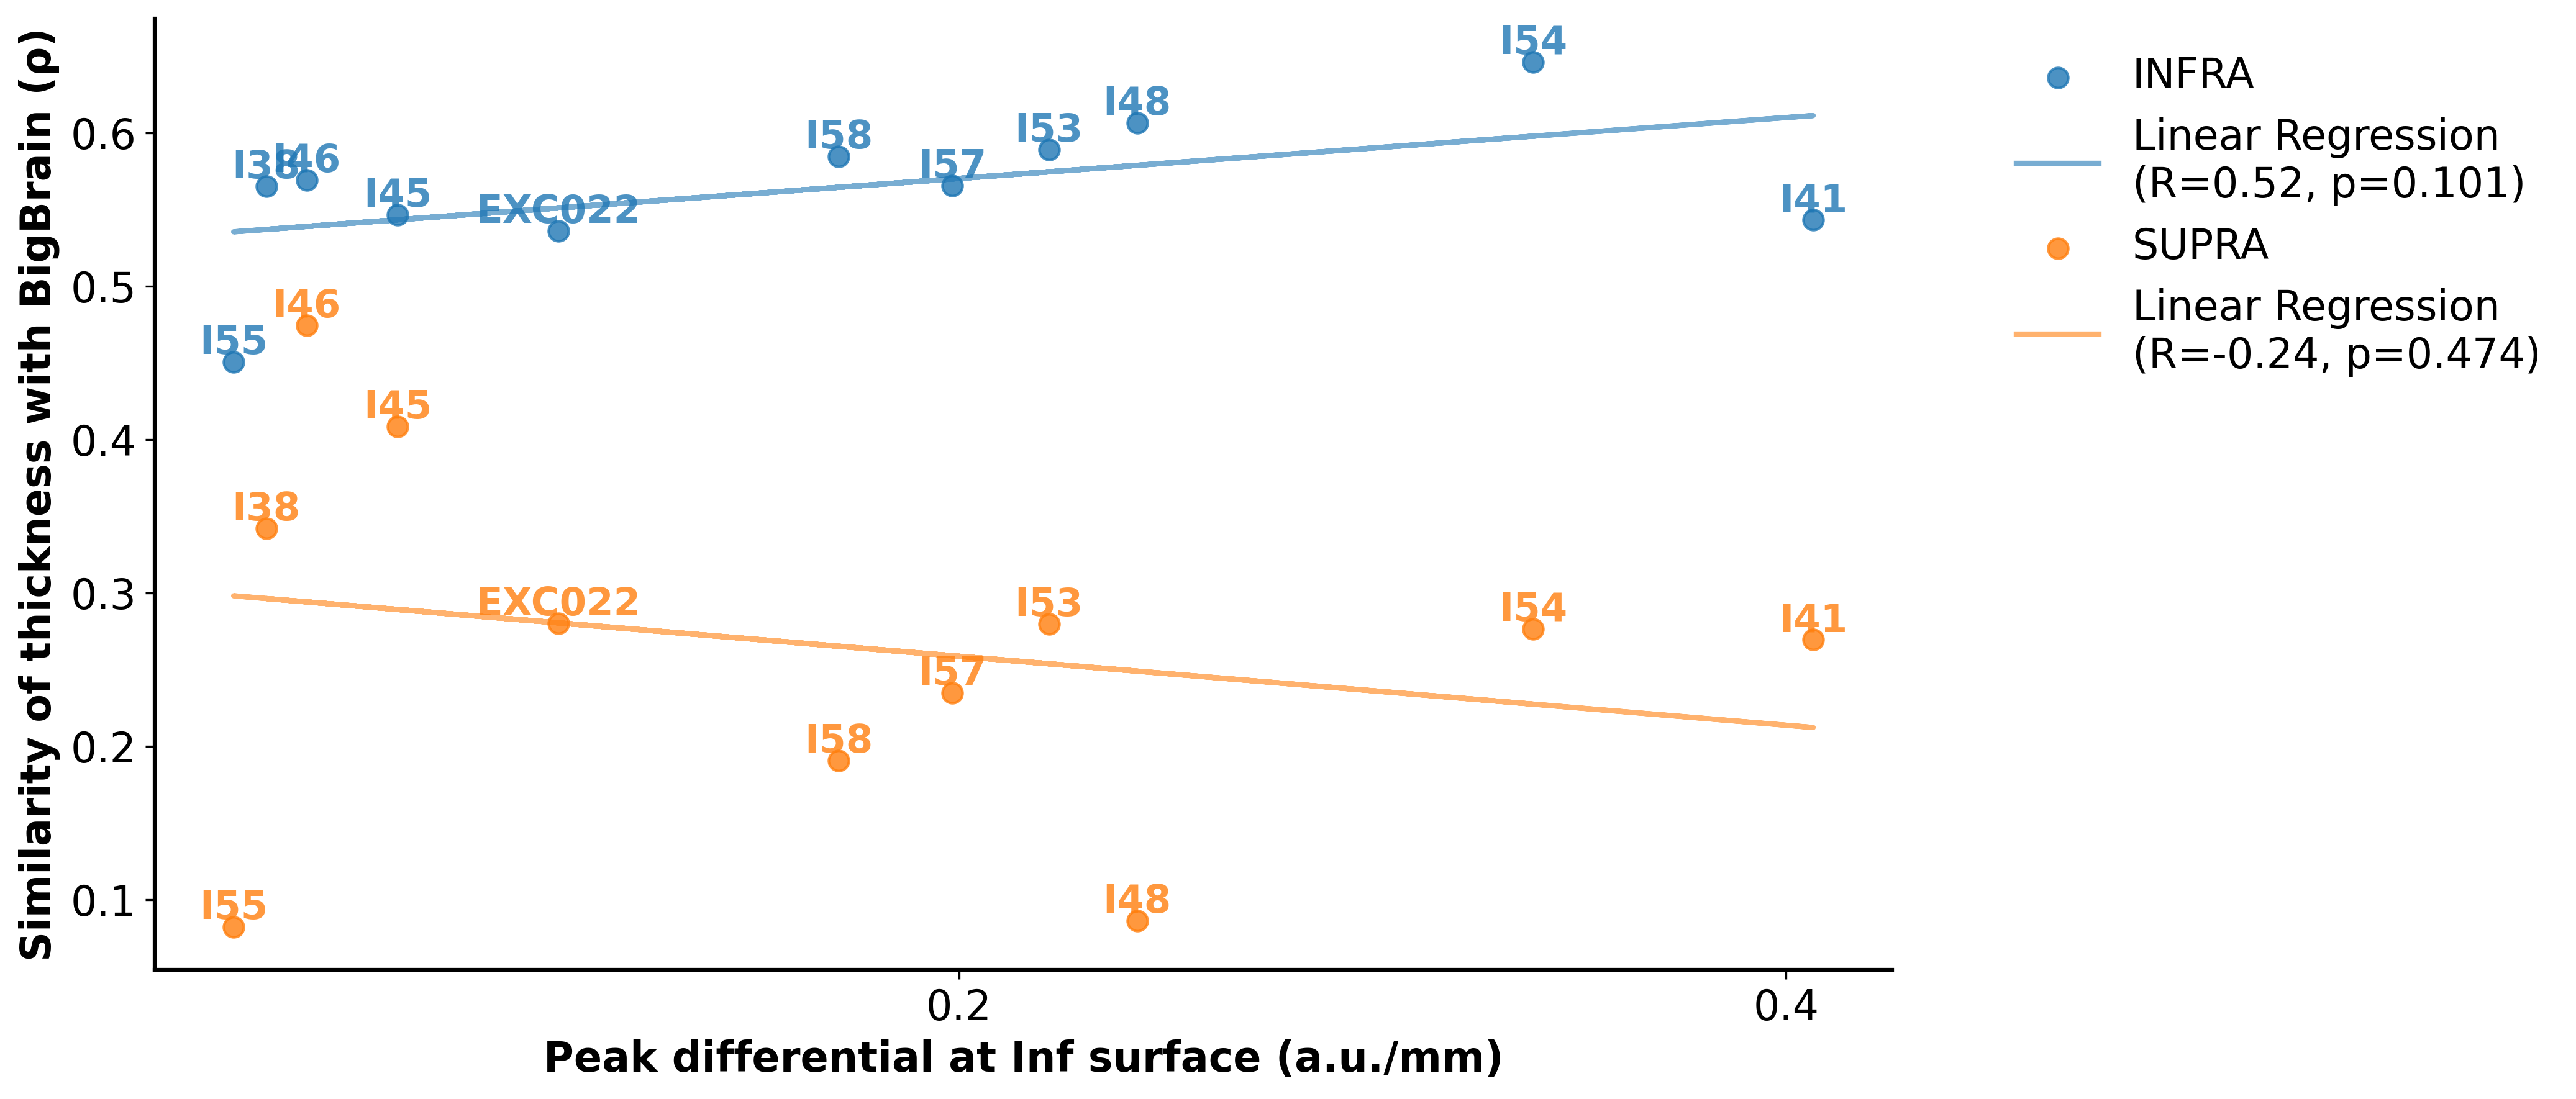

In [27]:

#load the correlation data (from visualize_brain.ipynb)
#/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/layer_project/cortical_layer/jupyter-notebook/visualization
'''
with open('/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/layer_project/cortical_layer/jupyter-notebook/visualization/thickness_corr_wrt_bigbrain_32k.pkl', 'rb') as f:
    data = pickle.load(f)
    subject_names_corr = data['subject_names']
    thickness_corr_wrt_bigbrain = data['thickness_corr_wrt_bigbrain']

'''
with open('/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/layer_project/cortical_layer/jupyter-notebook/visualization/thickness_corr_wrt_bigbrain.pkl', 'rb') as f:
    data = pickle.load(f)
    subject_names_corr = data['subject_names']
    thickness_corr_wrt_bigbrain = data['thickness_corr_wrt_bigbrain']

#get the reorder index of the subject names_corr[hemi] in subject_names
reorder_index = [subject_names.index(subject) for subject in subject_names_corr[hemi]]
#reorder subject_names with the reorder_index
subject_names_reordered = [subject_names[i] for i in reorder_index]
print('new',len(subject_names_reordered),subject_names_reordered)


fontsize = 16
voxels_all = [np.abs(at_inf_surface)]



plt.figure(figsize=(14,6), dpi=300)
for i, independent_variable in enumerate(voxels_all):
    var_= independent_variable[reorder_index]#this should be reordered so that it matches with the thickness_corr_wrt_bigbrain
    # Set high DPI for better quality

    for j, layer_type in enumerate(['infra','supra']):

        plt.scatter(var_[:-1], thickness_corr_wrt_bigbrain[hemi][layer_type][:-1], 
                    label=layer_type.upper(), s=60, alpha=0.8)
        #calculate linear regression
        slope, intercept, r_value, p_value, std_err = linregress(var_[:-1], thickness_corr_wrt_bigbrain[hemi][layer_type][:-1])
        
        #plot the linear regression
        plt.plot(var_, slope*var_ + intercept, 
                label=f'Linear Regression\n(R={r_value:.2f}, p={p_value:.3f})', linewidth=2, alpha=0.6)
        for i, subject in enumerate(subject_names_reordered):
            plt.annotate(subject, (var_[i], thickness_corr_wrt_bigbrain[hemi][layer_type][i]), 
                        fontsize=fontsize-1, ha='center', va='bottom', alpha=0.8, fontweight='bold',
                        color=plt.gca().collections[-1].get_facecolors()[0])


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=fontsize)  

plt.xlabel(f'Peak differential at {LAYER_TYPE.capitalize()} surface (a.u./mm)', fontsize=fontsize, fontweight='bold')
plt.ylabel('Similarity of thickness with BigBrain (ρ)', fontsize=fontsize, fontweight='bold')
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
#only set the minimum of x-axis

# Set fewer ticks on x-axis
plt.locator_params(axis='x', nbins=4)

#remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.tight_layout()
#save the figure
SUBPATH = 'corr_wrt_bigbrain_figure'
#create subfolder if it doesn't exist
#os.makedirs(SUBPATH, exist_ok=True)
#plt.savefig(f'{SUBPATH}/{hemi}_thickness_corr_wrt_bigbrain_{layer_type}_{RESOLUTION}.png', dpi=300)
#
#plt.close()
